In [1]:
## The following are few details about the approach taken to solve the problem:
## 1. I have used the data as is to predict into 5 classes and not a binary classification problem.
li = ['new','new','kek']

In [2]:
import pandas as pd
import string
import numpy as np

In [3]:
def load_embedding_model():
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-300")
    print("loaded vocan size %i"% len(wv_from_bin.index_to_key))   
    return wv_from_bin

In [4]:
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 376.1/376.1MB downloaded
loaded vocan size 400000


In [18]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ... ")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [5]:
def clean_data(corpus):
    corpus = corpus.lower()
    corpus = corpus.translate(str.maketrans('', '', string.punctuation))
    return corpus

In [6]:
def get_vocab(corpus):
    corpus_words = [x for line in corpus for x in line.split()]
    corpus_words = list(set(corpus_words))
    corpus_words = sorted(corpus_words)
    return corpus_words

In [7]:
get_vocab(["this is a great review", "this is a bad review"])

## test corpus

['a', 'bad', 'great', 'is', 'review', 'this']

In [8]:
def compute_co_occurence_matrix(corpus,window_size = 4):
    word2idx = {}
    sorted_corpus = get_vocab(corpus)
    for i in sorted_corpus:
        word2idx[i] = sorted_corpus.index(i)
    
    M = np.zeros((len(sorted_corpus),len(sorted_corpus)))
    M.dtype = 'int'

    for review in corpus:

        review_words = review.split()
        for i in range(len(review_words)):
            for j in range(max(0,i-window_size),min(i+window_size,len(review_words))):
                if i!=j:
                    M[word2idx[review_words[i]],word2idx[review_words[j]]] += 1
    return M,word2idx


In [9]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M):
    svd = TruncatedSVD(n_iter= 10, n_components=2, random_state=42)
    return svd.fit_transform(M)

In [10]:
from matplotlib import pyplot as plt
def plot_embeddings(M,word2index,words_to_plot):
    for w in words_to_plot:
        i = word2index[w]
        plt.scatter(M[i][0],M[i][1],marker='o',color='green')
        plt.annotate(w, (M[i][0],M[i][1]), arrowprops=dict(arrowstyle="->"))

In [11]:
reviews = pd.read_csv('amazon_reviews.csv')

In [20]:
corpus = reviews['reviewText'].fillna('').tolist()
corpus = [clean_data(x) for x in corpus]
vocab = get_vocab(corpus)
M,w2i = compute_co_occurence_matrix(corpus)

In [13]:
M = reduce_to_k_dim(M)

In [22]:
M_2,w2i_2 = get_matrix_of_vectors(wv_from_bin,vocab)

Shuffling words ... 
Putting 10000 words into word2ind and matrix M...
Done.


In [23]:
M_2 = reduce_to_k_dim(M_2)

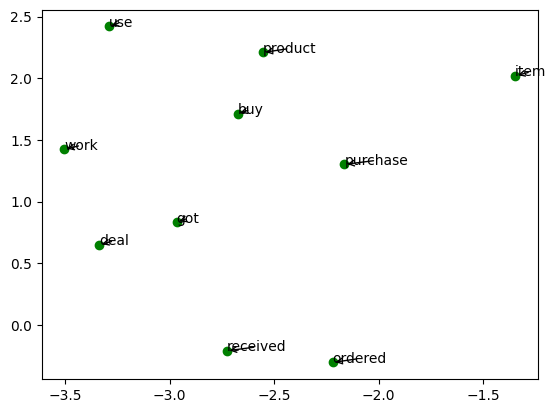

In [24]:
plot_embeddings(M_2,w2i_2,['purchase','buy','work','got','ordered','received','product','item','deal','use'])

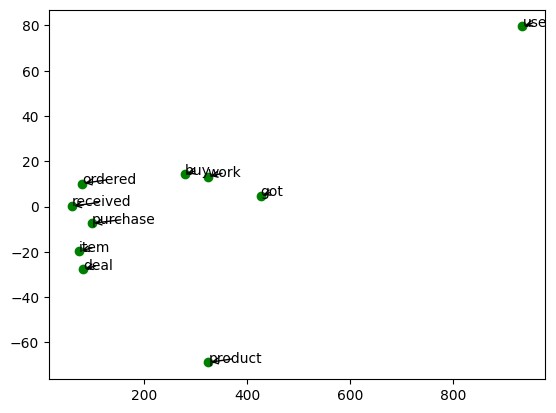

In [14]:
plot_embeddings(M,w2i,['purchase','buy','work','got','ordered','received','product','item','deal','use'])

In [15]:
print(M)

[[ 4.75837051e+00 -3.32122203e-01]
 [ 6.63099181e-02  5.53046556e-03]
 [ 2.24731152e-02  2.17441446e-03]
 ...
 [ 7.51750483e-01  1.32124090e-01]
 [ 1.16645184e+00 -7.20190961e-01]
 [ 1.28320455e+00 -2.88924037e-01]]


In [16]:
reviews.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
word_count_vector = vectorizer.fit_transform(reviews['reviewText'])


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
X = reviews['reviewText']
y = reviews['overall']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [ ]:
print('Total number of reviews for this profuct is: ', reviews.shape[0])
print('Number of reviews in training set is: ', X_train.shape[0])
print('Number of reviews in validation set is: ', X_val.shape[0])
print('Number of reviews in test set is: ', X_test.shape[0])

Total number of reviews for this profuct is:  4915
Number of reviews in training set is:  3932
Number of reviews in validation set is:  492
Number of reviews in test set is:  491
